In [ ]:
import random
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
colors_blindness = sns.color_palette("colorblind")

# Création des données

On démarre par créer des données homo et hétéro scédastiques. On crée aussi les vraies données.

In [ ]:
np.random.seed(43)

n = 300
X = np.random.uniform(low=0,high=5,size=n)
sigma = 0.5

## Homoscedastic model
Y_hom = np.cos(X) + sigma*np.random.normal(size=n)

y_true = np.cos(np.linspace(0,5,300))

## Heteroscedastic model
y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)



color_train = colors_blindness[1]
color_true = colors_blindness[4]
color_cal = colors_blindness[9]
color_test = colors_blindness[7]

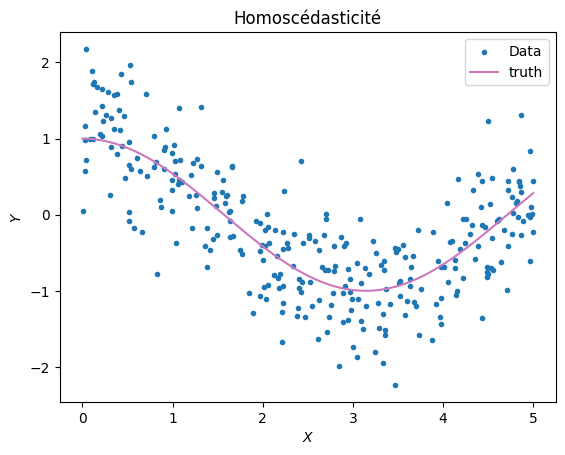

In [ ]:
plt.scatter(X,Y_hom,marker='.', label = "Data")
plt.plot(np.linspace(0,5,300),y_true, color = color_true, label ="truth")
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Homoscédasticité')
plt.legend()
plt.show()

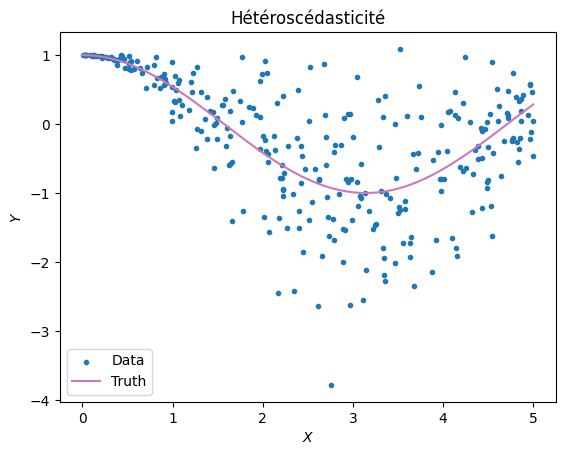

In [ ]:
plt.scatter(X,y,marker='.', label = "Data")
plt.plot(np.linspace(0,5,300),y_true, color = color_true, label = "Truth")
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Hétéroscédasticité')
plt.legend()
plt.show()

# Préparation des modèles

On sépare nos données en train/test, puis on configure la régression polynomiales en créant le tableau de variables $(1,X,X^2,X^3)$

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
# Data preparation (embedding)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(4)
Xpoly_train =  poly.fit_transform(X_train[:, np.newaxis]) # TODO OPERAND
Xpoly_test  =  poly.fit_transform(X_test[:, np.newaxis])   # TODO OPERAND

In [ ]:
Xpoly_train[:,3] - X_train**3

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42108547e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
        8.88178420e-16,  0.00000000e+00, -1.77635684e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.42108547e-14,  7.10542736e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.77635684e-15,  0.00000000e+00,
        0.00000000e+00, -4.44089210e-16,  0.00000000e+00, -7.10542736e-15,
        0.00000000e+00,  

# Regression polynomiale standard

On fitte une régression polynomiale sur les données polynomiales.

In [ ]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(fit_intercept=False)

# Fit linear regression
#
linear_reg.fit(Xpoly_train,y_train) #TODO LINE
#


LinearRegression(fit_intercept=False)

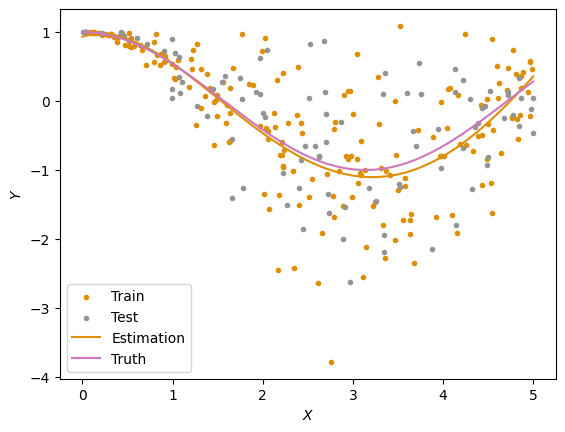

In [ ]:
# Visualization
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
aux = np.linspace(0,5,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
plt.plot(aux,linear_reg.predict(auxpoly),color=color_train,label="Estimation")
plt.plot(np.linspace(0,5,300),y_true, color = color_true, label = "Truth")

plt.legend()
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()


In [ ]:
# Some metrics of performance
y_pred = linear_reg.predict(Xpoly_test)
Rtwo_linear_reg = linear_reg.score(Xpoly_test,y_test)
print("R2 for linear regression (polynomial features): ",Rtwo_linear_reg)
RMSE_linear_reg = np.sqrt(np.mean((y_pred-y_test)**2))
print("RMSE for linear regression (polynomial features): ",RMSE_linear_reg)
RMSE_mean = np.sqrt(np.mean((np.mean(y_train)-y_test)**2))
print("RMSE for mean predictor: ",RMSE_mean)

R2 for linear regression (polynomial features):  0.10607616527474928
RMSE for linear regression (polynomial features):  1.333555312434268
RMSE for mean predictor:  1.4117577379283743


# Regression quantile

Nous faisons la même chose avec une régression quantile. Pour rappel, la régression quantile fitte un modèle linéaire sur la fonction quantile d'ordre $\tau$.
Ici, nous choisissons $\beta=0.1$ pour obtenir une couverture d'ordre $1-\beta=0.9$ (donc une couverture à 90%).

On veut un intervalle de prédiction symétrique, on fitte donc les quantiles d'ordre $1-\frac{\beta}{2}$ et $\frac{\beta}{2}$, qui entoure le quantile médian ($\beta=0.5$)

In [ ]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"



beta = 0.1
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')
qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')

# Fit Upper and Lower Quantile regression and median
qr_down.fit(Xpoly_train, y_train) #TODO LINE
qr_up.fit(Xpoly_train, y_train)   #TODO LINE
qr_med.fit(Xpoly_train, y_train)  #TODO LINE



QuantileRegressor(alpha=0)

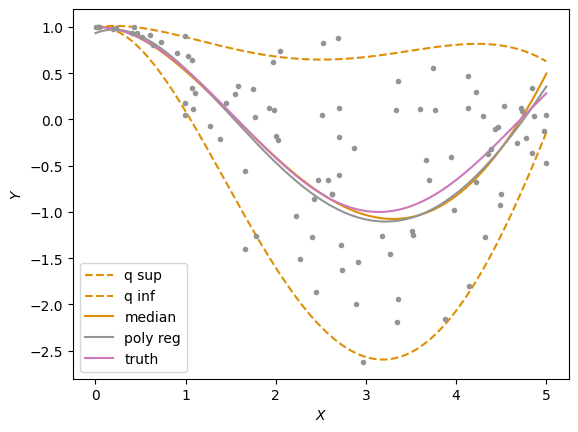

In [ ]:
plt.plot(aux,qr_up.predict(auxpoly),'--',color=color_train,label="q sup")
plt.plot(aux,qr_down.predict(auxpoly),'--',color=color_train,label="q inf")
plt.plot(aux,qr_med.predict(auxpoly),'-',color=color_train,label="median")
plt.plot(aux,linear_reg.predict(auxpoly),'-',color=color_test,label="poly reg")
plt.plot(np.linspace(0,5,300),y_true, color = color_true,label = "truth")

plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()

# Coverage

Le principal problème que nous allons rencontrer, c'est d'évaluer la couverture réelle du modèle. Autrement dit:
"Si j'ai de nouvelles données, est ce que mes intervalles de prédiction ont bien une couverture d'au moins 90%?"

In [ ]:
y_up_train = qr_up.predict(Xpoly_train)
y_up_test = qr_up.predict(Xpoly_test)
y_down_train = qr_down.predict(Xpoly_train)
y_down_test = qr_down.predict(Xpoly_test)

In [ ]:
# Count how many times the true label was indeed
# in the prediction interval on the test set



# Compute and print theoretical and empirical coverage
theor_cov = 1-beta # TODO OPERAND

prop_covered_qr  = np.sum((y_down_test<=y_test)*(y_test<=y_up_test))/len(y_test) # TODO OPERAND

print("Theoretical coverage: ", theor_cov)
print("Empirical coverage with QR: ", prop_covered_qr)


Theoretical coverage:  0.9
Empirical coverage with QR:  0.8787878787878788


In [ ]:
def coverage_n(n,beta):
  X = np.random.uniform(low=0,high=5,size=n)
  sigma = 0.5
  y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)


  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)


  Xpoly_train =  poly.fit_transform(X_train[:, np.newaxis]) # TODO OPERAND
  Xpoly_test  =  poly.fit_transform(X_test[:, np.newaxis])

  qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
  qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')

  qr_down.fit(Xpoly_train, y_train) #TODO LINE
  qr_up.fit(Xpoly_train, y_train)   #TODO LIN

  y_up_train = qr_up.predict(Xpoly_train)
  y_up_test = qr_up.predict(Xpoly_test)
  y_down_train = qr_down.predict(Xpoly_train)
  y_down_test = qr_down.predict(Xpoly_test)

  prop_covered_qr  = np.sum((y_down_test<=y_test)*(y_test<=y_up_test))/len(y_test) # TODO OPERAND
  return prop_covered_qr


In [ ]:
cov = []
for i in range(200):
  cov.append(coverage_n(1000,0.1))

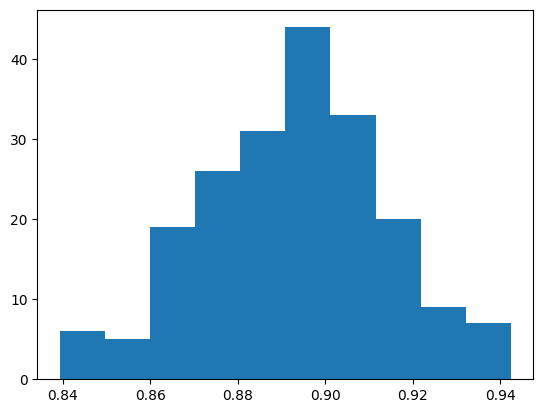

0.8927121212121212


In [ ]:
plt.hist(cov)
plt.show()
print(np.mean(np.array(cov)))